In [1]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/nature_12K.zip"
extract_dir = "/content/nature"

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import os

import wandb
from pytorch_lightning.loggers import WandbLogger

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

import matplotlib.pyplot as plt

In [2]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 48.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

## CNN Model


In [3]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F

class LitCNN(pl.LightningModule):
    def __init__(self, config):
        super().__init__()

        config_dict = dict(config)
        self.save_hyperparameters(config_dict)

        activation_fn = {
            "relu": nn.ReLU(),
            "gelu": nn.GELU(),
            "silu": nn.SiLU(),
            "mish": nn.Mish()
        }[config_dict["activation"]]

        filters = config_dict["filters"]
        kernel_size = config_dict["kernel_size"]
        dropout = config_dict["dropout"]

        layers = []
        in_channels = 3

        for f in filters:
            layers.append(nn.Conv2d(in_channels, f, kernel_size, padding=1))
            layers.append(activation_fn)
            layers.append(nn.MaxPool2d(2))
            in_channels = f

        self.conv = nn.Sequential(*layers)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(filters[-1], config_dict["dense_neurons"])
        self.output = nn.Linear(config_dict["dense_neurons"], 10)

        # Store final metrics for printing
        self.final_train_loss = 0.0
        self.final_train_acc = 0.0
        self.final_val_loss = 0.0
        self.final_val_acc = 0.0

    def forward(self, x):
        x = self.conv(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        return self.output(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = F.cross_entropy(preds, y)
        acc = (preds.argmax(dim=1) == y).float().mean()
        self.final_train_loss = loss.item()
        self.final_train_acc = acc.item()
        self.log("train_loss", loss)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = F.cross_entropy(preds, y)
        acc = (preds.argmax(dim=1) == y).float().mean()
        self.final_val_loss = loss.item()
        self.final_val_acc = acc.item()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = F.cross_entropy(preds, y)
        acc = (preds.argmax(dim=1) == y).float().mean()
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        return {"test_loss": loss, "test_acc": acc}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams["lr"])

    def on_train_end(self):
        # Print final stats at the end of training
        print(f"\nTrain Loss={self.final_train_loss:.4f}, Train Acc={self.final_train_acc:.4f}, "
              f"Val Loss={self.final_val_loss:.4f}, Val Acc={self.final_val_acc:.4f}")


## Dataset Preparation

In [4]:
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import os
import pytorch_lightning as pl

class INaturalistDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=64, augment=False, num_workers=2):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.augment = augment
        self.num_workers = num_workers

    def setup(self, stage=None):
        train_path = os.path.join(self.data_dir, "train")
        test_path = os.path.join(self.data_dir, "test")

        base_transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor()
        ])

        augment_transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor()
        ])

        full_train_dataset = datasets.ImageFolder(train_path, transform=augment_transform if self.augment else base_transform)
        test_dataset = datasets.ImageFolder(test_path, transform=base_transform)

        targets = np.array(full_train_dataset.targets)
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        for train_idx, val_idx in sss.split(np.zeros(len(targets)), targets):
            self.train_dataset = Subset(full_train_dataset, train_idx)
            self.val_dataset = Subset(full_train_dataset, val_idx)

        self.test_dataset = test_dataset

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)


# Sweeping

In [ ]:
import wandb
from pytorch_lightning.loggers import WandbLogger

def train_model(config=None):
    with wandb.init(config=config) as run:
        config = wandb.config

        run.name = (
            f"lr_{config.lr}_bs_{config.batch_size}_do_{config.dropout}_"
            f"{config.activation}_filters_{'-'.join(map(str, config.filters))}_"
            f"ks_{config.kernel_size}_dn_{config.dense_neurons}_"
            f"aug_{config.augment}_bn_{config.batch_norm}_fp16_{config.fp16}"
        )
        run.save()

        datamodule = INaturalistDataModule(
            data_dir="/content/nature/inaturalist_12K",
            batch_size=config.batch_size,
            augment=config.augment
        )
        datamodule.setup()

        model = LitCNN(config)

        wandb_logger = WandbLogger(project="cnn-nature", log_model="all")

        trainer = pl.Trainer(
            accelerator='gpu',
            devices=1,
            max_epochs=10,
            logger=wandb_logger,
            precision=16 if config.get("fp16", False) else 32,
        )

        trainer.fit(model, datamodule=datamodule)

In [ ]:
sweep_config = {
    "method": "random",
    "metric": {"name": "val_acc", "goal": "maximize"},
    "parameters": {
        "lr": {"values": [1e-2, 1e-3, 1e-4]},
        "batch_size": {"values": [32, 64]},
        "dropout": {"values": [0.2, 0.3]},
        "activation": {"values": ["relu", "gelu", "silu", "mish"]},
        "filters": {"values": [[32]*5, [32, 64, 128, 128, 256], [64]*5]},
        "kernel_size": {"values": [3, 5]},
        "dense_neurons": {"values": [128, 256]},
        "augment": {"values": [True, False]},
        "batch_norm": {"values": [True, False]},
        "fp16": {"values": [True, False]}
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Assignment2_Attempt1")
wandb.agent(sweep_id, function=train_model, count=100)

Create sweep with ID: kdpswt7u
Sweep URL: https://wandb.ai/vinyk-sd-indian-institute-of-technology-madras/Assignment2_Attempt1/sweeps/kdpswt7u


wandb: Agent Starting Run: tzy8h5bj with config:
wandb: 	activation: mish
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	filters: [32, 32, 32, 32, 32]
wandb: 	fp16: False
wandb: 	kernel_size: 5
wandb: 	lr: 0.0001


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | conv    | Sequential        | 104 K  | train
1 | gap     | AdaptiveAvgP

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.



Train Loss=1.9751, Train Acc=0.1613, Val Loss=2.2250, Val Acc=0.1875


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇█████
train_acc,▁▂▃▃▃▄▂▅▅▂▅▃▅▄▄▆▅▅▅█▅▅▆▇▅▇▄▅▇▅▆▆▆▇▅▅▆▇▅▄
train_loss,▇▇▇▆▆▆▆▇▅▅▆▆▅█▅▄▅▆▅▃▆▄▆▃▄▃▅▁▅▃▄▅▃▄▅▄▃▄▅▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_acc,▁▂▄▅▅▆▇▇█▇
val_loss,██▆▄▄▃▂▂▁▂
epoch,9
train_acc,0.16129
train_loss,1.97514
trainer/global_step,2499
val_acc,0.2475


wandb: Agent Starting Run: dol1wkdo with config:
wandb: 	activation: relu
wandb: 	augment: True
wandb: 	batch_norm: False
wandb: 	batch_size: 64
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	filters: [64, 64, 64, 64, 64]
wandb: 	fp16: True
wandb: 	kernel_size: 3
wandb: 	lr: 0.01


/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightni

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.



Train Loss=2.3034, Train Acc=0.1111, Val Loss=2.2970, Val Acc=0.1250


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇████
train_acc,▃▇▃█▁▃▄▅▇▆█▃▅▁▆▂▂▇▅▁▁▅▂▄▅
train_loss,▄▁█▂▄█▄▂▃▂▂▅▄▅▃▄▄▃▃▄▅▂▃▄▃
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▅▁█▄▄▄▂▄▂▇
epoch,9
train_acc,0.11111
train_loss,2.30339
trainer/global_step,1249
val_acc,0.1


wandb: Agent Starting Run: l0r935p7 with config:
wandb: 	activation: mish
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	filters: [32, 32, 32, 32, 32]
wandb: 	fp16: False
wandb: 	kernel_size: 5
wandb: 	lr: 0.01


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | conv    | Sequential        | 104 K  | train
1 | gap     | AdaptiveAvgP

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.



Train Loss=2.3095, Train Acc=0.0323, Val Loss=2.2992, Val Acc=0.1875


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████
train_acc,▄▁█▄▃▅▃▆▃▁▃▇▄▃▅▄▃▃▃▅▄▆▄▂▃▅▂▂▂▇▄█▄▆▃▅█▅▃▂
train_loss,▅▇▄▄▅▄▆▃▄▅▄▃▃▄▄▃▆▅▃▄█▅▄▄▄▅▄▆▄▃▅▃▄▃▅▅▁▄▅▅
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▄▁▄▄█▅▄▄▃▅
epoch,9
train_acc,0.03226
train_loss,2.30948
trainer/global_step,2499
val_acc,0.1


wandb: Agent Starting Run: n5zghpme with config:
wandb: 	activation: gelu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	filters: [32, 32, 32, 32, 32]
wandb: 	fp16: True
wandb: 	kernel_size: 5
wandb: 	lr: 0.001


/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightni

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.



Train Loss=1.8046, Train Acc=0.3333, Val Loss=1.8836, Val Acc=0.3125


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇████
train_acc,▁▂▃▁▄▃▄▅▃▃▅▄▆▅▆█▆▇▆▆██▇▇▇
train_loss,█▇▇█▇▆▅▅▇▅▃▄▄▄▂▃▃▂▃▃▁▁▄▄▁
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▃▅▄▆▆▇▆██
val_loss,█▇▆▅▄▄▃▄▂▁
epoch,9
train_acc,0.33333
train_loss,1.80458
trainer/global_step,1249
val_acc,0.329


wandb: Agent Starting Run: nsw3th8e with config:
wandb: 	activation: relu
wandb: 	augment: False
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	filters: [64, 64, 64, 64, 64]
wandb: 	fp16: False
wandb: 	kernel_size: 3
wandb: 	lr: 0.0001


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | conv    | Sequential        | 149 K  | train
1 | gap     | AdaptiveAvgP

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.



Train Loss=2.0533, Train Acc=0.3226, Val Loss=2.1438, Val Acc=0.1250


epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇█
train_acc,▂▂▂▃▂▃▄▄▃▅▄▄▃▇▅▃▄█▂▄▃▄▄▄▁▅▃▃▃▆▄▅▇▅▂█▄▆▅▆
train_loss,▇▇▇█▇▆▅▅▅▄▂▄▃▄▅▃▃▅▄▅▄█▅▅▇▅▄▆▄▁▄▄▃▄▄▁▁▁▃▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
val_acc,▁▅▆▆▇▆█▇█▇
val_loss,█▄▃▃▃▂▂▂▁▁
epoch,9
train_acc,0.32258
train_loss,2.05333
trainer/global_step,2499
val_acc,0.2235


wandb: Agent Starting Run: bt7q8jjm with config:
wandb: 	activation: mish
wandb: 	augment: False
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	dense_neurons: 128
wandb: 	dropout: 0.3
wandb: 	filters: [64, 64, 64, 64, 64]
wandb: 	fp16: False
wandb: 	kernel_size: 3
wandb: 	lr: 0.01


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | conv    | Sequential        | 149 K  | train
1 | gap     | AdaptiveAvgP

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.



Train Loss=2.3059, Train Acc=0.1111, Val Loss=2.2935, Val Acc=0.1875


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇████
train_acc,▂▅▅▄▁▄▅▃▆▄█▂▆▂▅▅▆▂▇▁▂▆▅▇▅
train_loss,▆▄▆▆▅▅▂▆▄▅▁▅▄▅▅▄▃█▃▄▆▂▇▄▅
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁█▁
epoch,9
train_acc,0.11111
train_loss,2.30589
trainer/global_step,1249
val_acc,0.1


wandb: Agent Starting Run: 7euy9rj2 with config:
wandb: 	activation: mish
wandb: 	augment: False
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	filters: [32, 32, 32, 32, 32]
wandb: 	fp16: False
wandb: 	kernel_size: 3
wandb: 	lr: 0.001


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | conv    | Sequential        | 37.9 K | train
1 | gap     | AdaptiveAvgP

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.



Train Loss=1.9403, Train Acc=0.2698, Val Loss=2.0478, Val Acc=0.0625


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇████
train_acc,▁▂▁▄▄▁▅▅▅▄▄▆▅▄██▅▆▆▃▇▅█▅▅
train_loss,█▇█▅▇▅▅▅▄▄▆▃▄▅▁▃▃▂▃▅▂▅▂▅▂
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
val_acc,▁▄▅▅▆▇█▇██
val_loss,█▅▅▄▃▂▂▂▁▁
epoch,9
train_acc,0.26984
train_loss,1.94026
trainer/global_step,1249
val_acc,0.2645


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tbm8ji53 with config:
wandb: 	activation: relu
wandb: 	augment: True
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	filters: [32, 32, 32, 32, 32]
wandb: 	fp16: False
wandb: 	kernel_size: 5
wandb: 	lr: 0.001


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | conv    | Sequential        | 104 K  | train
1 | gap     | AdaptiveAvgP

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.



Train Loss=2.0595, Train Acc=0.4194, Val Loss=2.0295, Val Acc=0.2500


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_acc,▃▂▁▃▁▂▂▃▃▃▆▁▂▂▄▆▃▄▆▂▃▄▅▃▃▃▅▄▅▃▅▄▆▄▃▆▄▃██
train_loss,██▇▆▇▇▇▇▇▅█▆▇▆▇▄▇▅▇▇▇▅▇▅▄▆▆▆▅▄▅▅▄▄▃▄▃▃▁▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▁▁▃▃▅▆▅███
val_loss,█▇▆▆▅▄▄▂▁▁
epoch,9
train_acc,0.41935
train_loss,2.05948
trainer/global_step,2499
val_acc,0.255


wandb: Agent Starting Run: 770je7va with config:
wandb: 	activation: silu
wandb: 	augment: True
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	filters: [32, 64, 128, 128, 256]
wandb: 	fp16: False
wandb: 	kernel_size: 3
wandb: 	lr: 0.001


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | conv    | Sequential        | 536 K  | train
1 | gap     | AdaptiveAvgP

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.



Train Loss=1.8166, Train Acc=0.3226, Val Loss=1.8113, Val Acc=0.4375


epoch,▁▁▁▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████
train_acc,▁▂▁▄▄▅▃▅▅▃▅▄▅▄▃▄▃▆▃▃▅▅▅▂▄▃▃█▅▃▅▅█▆▅▆▇▆▅▆
train_loss,█▆▇▆▅▆▆▅▅▅▄▄▄▆▆▆▆▄▅▅▅▅▅▇▃▅▃▄▆▄▃▂▄▃▁▁▂▂▅▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_acc,▁▂▃▃▂▅▅▆▇█
val_loss,█▇▆▆▇▃▄▂▂▁
epoch,9
train_acc,0.32258
train_loss,1.81661
trainer/global_step,2499
val_acc,0.3145


wandb: Agent Starting Run: 6a8n0on0 with config:
wandb: 	activation: gelu
wandb: 	augment: False
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.2
wandb: 	filters: [64, 64, 64, 64, 64]
wandb: 	fp16: False
wandb: 	kernel_size: 3
wandb: 	lr: 0.01


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | conv    | Sequential        | 149 K  | train
1 | gap     | AdaptiveAvgP

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
print(torch.cuda.is_available())  # True if GPU is available
print(torch.cuda.current_device())  # Print current GPU device
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # Print GPU name

True
0
Tesla T4


## Testing best Model

Once the best hyperparameters are obtained from the sweep, we use it to train the same model and test it on the test dataset.

The best hyperparameters are selected and the trained model is tested on the test set.

In [6]:
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

# 1. Define the best config
best_config = {
    "lr": 0.01,
    "batch_size": 64,
    "dropout": 0.3,
    "activation": "gelu",
    "filters": [32, 64, 128, 128, 256],
    "kernel_size": 5,
    "dense_neurons": 256,
    "augment": True,
    "fp16": True
}

# 2. Create the DataModule
datamodule = INaturalistDataModule(
    data_dir="/content/nature/inaturalist_12K",
    batch_size=best_config["batch_size"],
    augment=best_config["augment"]
)

datamodule.setup()

# 3. Create the model
model = LitCNN(best_config)

In [9]:
# 4. Add test_step to the model if not already present
def test_step(self, batch, batch_idx):
    x, y = batch
    preds = self(x)
    loss = F.cross_entropy(preds, y)
    acc = (preds.argmax(dim=1) == y).float().mean()
    self.log("test_loss", loss, prog_bar=True)
    self.log("test_acc", acc, prog_bar=True)
    return {"test_loss": loss, "test_acc": acc}
LitCNN.test_step = test_step  # Dynamically add it to your class

# 5. Save best model using checkpoint
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    filename="best-cnn-model",
    save_top_k=1
)

logger = CSVLogger("lightning_logs", name="cnn_best_run")

trainer = Trainer(
    max_epochs=20,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    precision=16 if best_config["fp16"] else 32,
    callbacks=[checkpoint_callback],
    logger=logger
)

/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:513: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
INFO:pytorch_lightning.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [10]:
# 6. Train the model
trainer.fit(model, datamodule=datamodule)

# 7. Save the trained model manually as .pth
torch.save(model.state_dict(), "best_model.pth")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | conv    | Sequential        | 1.5 M  | train
1 | gap     | AdaptiveAvgPool2d | 0      | train
2 | dropout | Dropout           | 0      | train
3 | fc1     | Linear            | 65.8 K | train
4 | output  | Linear            | 2.6 K  | train
------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.225     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.



Train Loss=2.3006, Train Acc=0.0952, Val Loss=2.3030, Val Acc=0.1250


In [7]:
model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [ ]:
trainer.test(model, dataloaders=datamodule.test_dataloader())

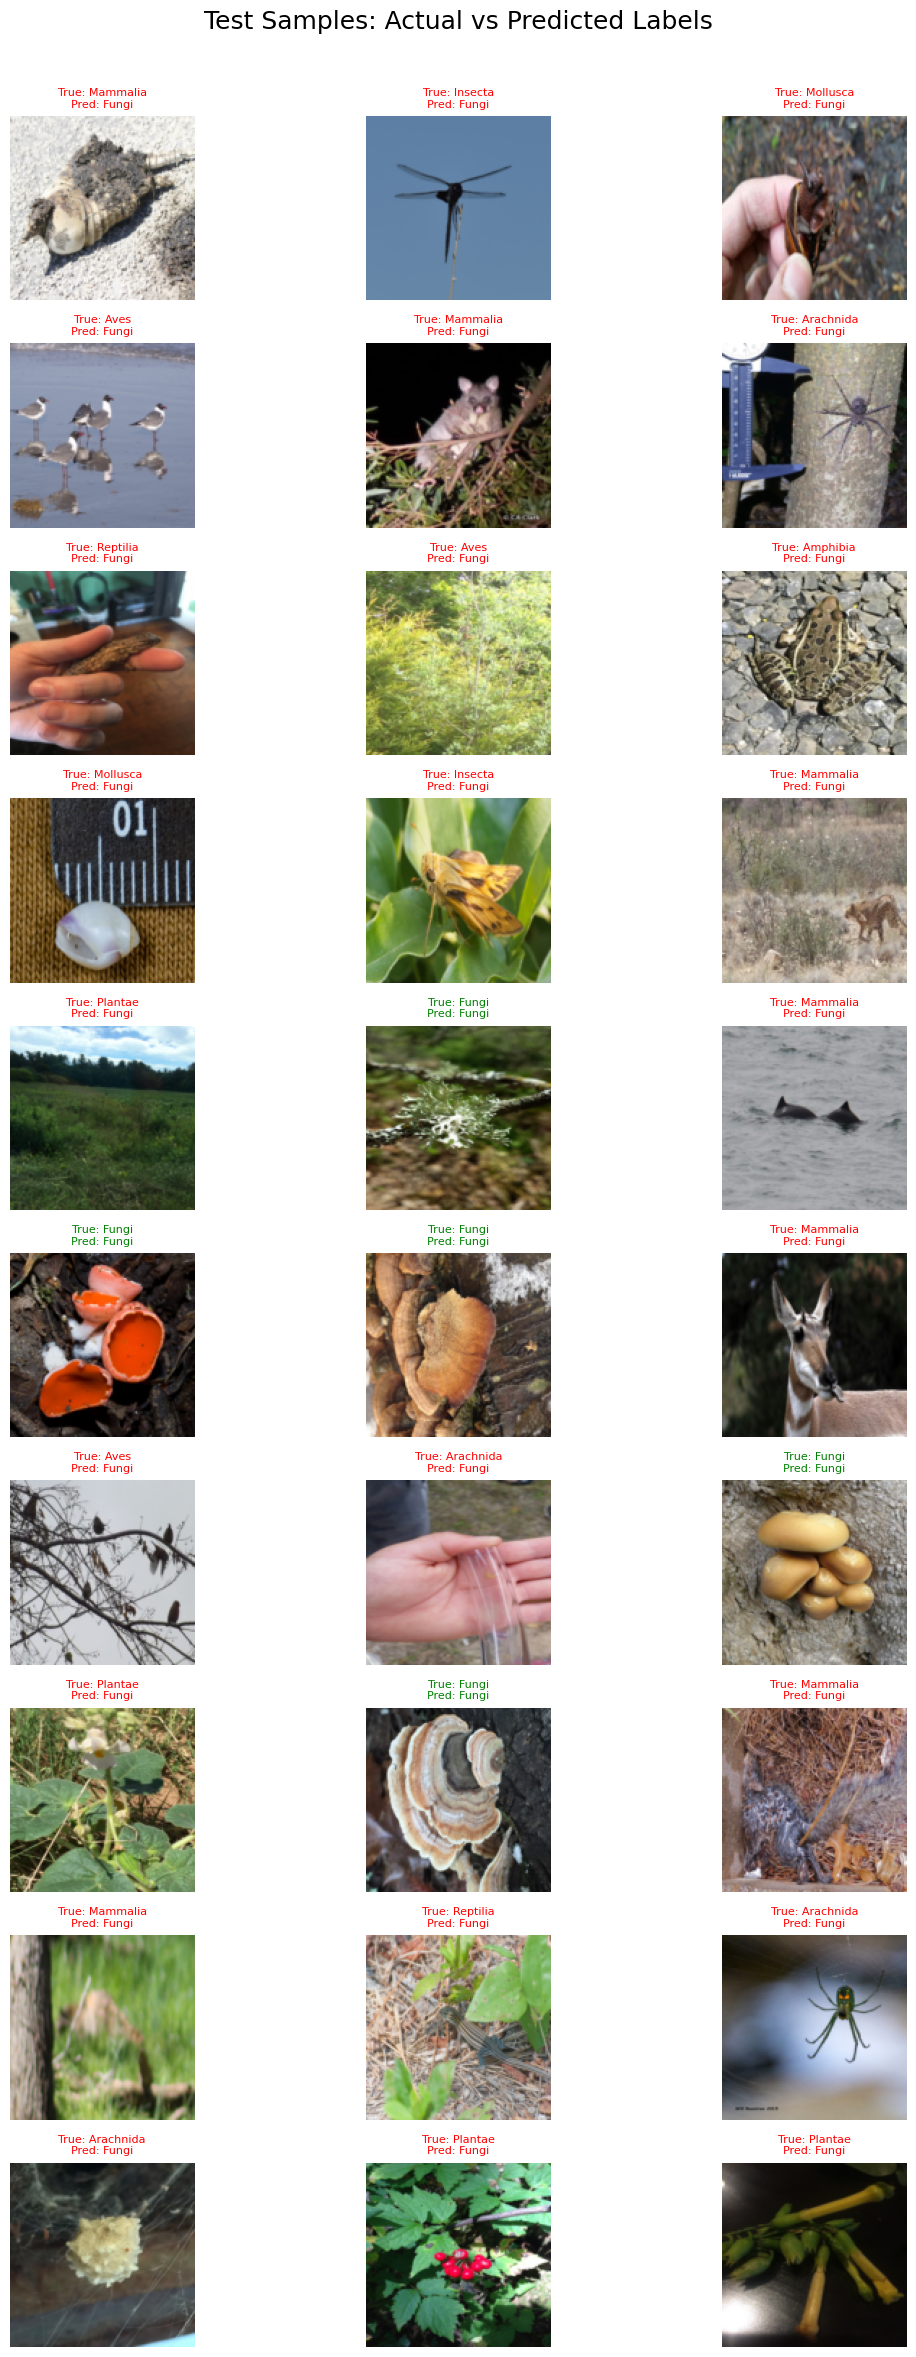

In [14]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load("best_model.pth"))
model.eval()
model.to(device)

test_loader = DataLoader(datamodule.test_dataset, batch_size=1, shuffle=True)

class_names = datamodule.test_dataset.classes

samples = []
for img, label in test_loader:
    if len(samples) >= 30:
        break
    img = img.to(device)
    with torch.no_grad():
        output = model(img)
        pred = torch.argmax(output, dim=1).cpu().item()
    samples.append((img.cpu().squeeze(0), label.item(), pred))

# Plot 10×3 grid
fig, axes = plt.subplots(10, 3, figsize=(12, 24))
fig.suptitle("Test Samples: Actual vs Predicted Labels", fontsize=18)

for ax, (img, true_label, pred_label) in zip(axes.flat, samples):
    img = img.permute(1, 2, 0).numpy()  # C×H×W -> H×W×C
    ax.imshow(img)
    ax.axis('off')
    title_color = "green" if true_label == pred_label else "red"
    ax.set_title(
        f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}",
        fontsize=8,
        color=title_color
    )

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
